In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr

In [2]:
fanv3Input = {'manure':37.5, 'fertilizer':82.6, 'fixation':12.2, 'deposition':18.8}
fanv3Output = {'$NH_3$':24.8, 'NO':5.2, '$N_2O$':7.1, '$N_2$':42.8, 'runoff':31.8, 'harvest':30.8, 'fire':3.1}
clmInput = {'manure':29.1, 'fertilizer':82.6, 'fixation':11.5, 'deposition':18.7}
clmOutput = {'$NH_3$':0, 'NO':6.1, '$N_2O$':7.9, '$N_2$':44.3, 'runoff':28.9, 'harvest':36.7, 'fire':3.4}

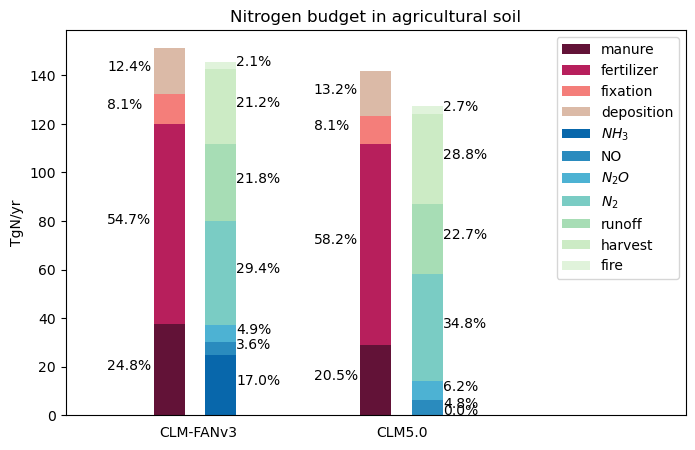

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#621237', '#b71f5c', '#f47e7a', '#dbbaa7']
palette = sns.color_palette(palette='GnBu', n_colors=7)
palette.reverse()
bottom = [0, 0]
for i, key in enumerate(fanv3Input.keys()):
    ax.bar([0.1, 0.3], [fanv3Input.get(key), clmInput.get(key)], width=0.03, bottom=bottom, label=key, color=colors[i])

    yp = (bottom[0]*2+fanv3Input.get(key))/2
    per = round(fanv3Input.get(key)*100/sum(fanv3Input.values()), 1)
    ax.text(x=0.1-0.06, y=yp, s=str(per)+'%')

    yp = (bottom[1]*2+clmInput.get(key))/2
    per = round(clmInput.get(key)*100/sum(clmInput.values()), 1)   
    ax.text(x=0.3-0.06, y=yp, s=str(per)+'%')
    bottom[0] = bottom[0] + fanv3Input.get(key)
    bottom[1] = bottom[1] + clmInput.get(key)

bottom = [0, 0]
for i, key in enumerate(fanv3Output.keys()):
    ax.bar([0.15, 0.35], [fanv3Output.get(key), clmOutput.get(key)], width=0.03, bottom=bottom, label=key, color=palette[i])
    yp = (bottom[0]*2+fanv3Output.get(key))/2
    per = round(fanv3Output.get(key)*100/sum(fanv3Output.values()), 1)
    ax.text(x=0.15+0.015, y=yp, s=str(per)+'%')

    yp = (bottom[1]*2+clmOutput.get(key))/2
    per = round(clmOutput.get(key)*100/sum(clmOutput.values()), 1)   
    ax.text(x=0.35+0.015, y=yp, s=str(per)+'%')

    bottom[0] = bottom[0] + fanv3Output.get(key)
    bottom[1] = bottom[1] + clmOutput.get(key)

ax.set_xlim(0, 0.6)
ax.set_xticks([])
ax.text(x=0.09, y=-9, s='CLM-FANv3')
ax.text(x=0.3, y=-9, s='CLM5.0')
ax.set_ylabel("TgN/yr")
ax.set_title("Nitrogen budget in agricultural soil")
ax.legend(loc='upper right')
fig.savefig('graphs/NitrogenBudget.svg', dpi=300)
plt.show()

In [6]:
dsBOOI4 = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/MESONET_BOOI4.txt", sep=',')

In [7]:
dsBOOI4['valid'] = pd.to_datetime(dsBOOI4['valid'])
dsBOOI4 = dsBOOI4.set_index('valid')
dsBOOI4

,station,tmpf,relh,solar,precip,speed,drct,et,soil04t,soil12t,soil24t,soil50t,soil12vwc,soil24vwc,soil50vwc,bp_mb
valid,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,BOOI4,7.4120,85.2,0.0,0.0,11.048247,58.05,0.000079,23.2448,29.6564,34.6784,40.5896,12.1,5.7,7.4,-99
2014-01-01 01:00:00,BOOI4,7.3940,86.2,0.0,0.0,12.808718,54.16,0.000118,23.1962,29.6240,34.6442,40.5626,12.1,5.7,7.4,-99
2014-01-01 02:00:00,BOOI4,7.1240,86.8,0.0,0.0,13.900346,56.27,0.000118,23.1242,29.6006,34.6478,40.5500,12.1,5.7,7.4,-99
2014-01-01 03:00:00,BOOI4,6.8360,86.5,0.0,0.0,13.285187,51.06,0.000079,23.0612,29.6078,34.6172,40.5752,12.1,5.7,7.4,-99
2014-01-01 04:00:00,BOOI4,6.5120,87.7,0.0,0.0,12.139874,34.42,0.000079,22.9946,29.5862,34.6640,40.5698,12.1,5.7,7.4,-99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,BOOI4,25.3220,92.9,0.0,0.0,7.090000,344.00,0.000200,33.9422,38.4458,41.5796,45.5720,30.3,9.0,17.5,-99
2023-12-31 20:00:00,BOOI4,24.9152,93.4,0.0,0.0,6.828000,347.10,0.000200,33.9134,38.3648,41.5418,45.5810,30.3,9.0,17.5,-99
2023-12-31 21:00:00,BOOI4,24.1862,91.9,0.0,0.0,7.313000,354.70,0.000200,33.8774,38.3630,41.5580,45.5756,30.3,9.1,17.5,-99


In [16]:
print(dsBOOI4.index[dsBOOI4.index.duplicated()])

DatetimeIndex(['2016-11-06 01:00:00', '2017-11-05 01:00:00',
               '2018-11-04 01:00:00', '2019-11-03 01:00:00',
               '2020-11-01 01:00:00', '2021-11-07 01:00:00',
               '2022-11-06 01:00:00', '2023-11-05 01:00:00'],
              dtype='datetime64[ns]', name='valid', freq=None)


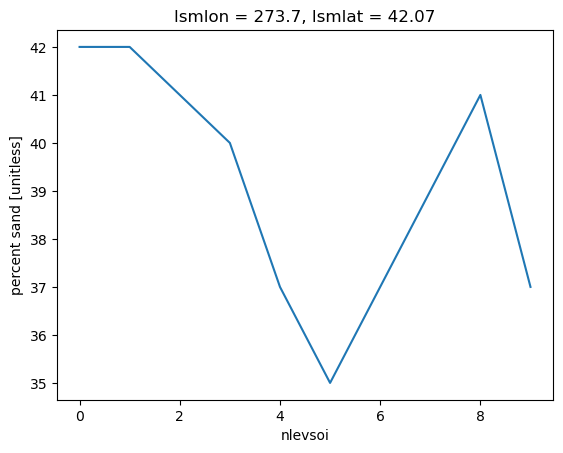

In [12]:
ds = xr.open_dataset("/glade/work/jinmuluo/MESONET/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2000_isu_point_c230824_original.nc")
ds['PCT_SAND'].plot()

In [2]:
ds=xr.open_dataset("/glade/work/jinmuluo/MESONET/ctsm51_params.c240105.mesocosm.nc")
print(ds["k_nitr_max_perday"].values)

0.1


In [10]:
ds = xr.open_dataset('/glade/derecho/scratch/jinmuluo/archive/ctsm53027_LEACHING_hist/lnd/hist/ctsm53027_LEACHING_hist.clm2.h0.2009-06.nc')